# Prédire le sentiments des tweets


## Connaitre ces données

### Détails des données

In [43]:
# les imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.impute import SimpleImputer
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [44]:
df = pd.read_csv('data.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [45]:
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date


In [46]:
df['tweet_created']

0        2015-02-24
1        2015-02-24
2        2015-02-24
3        2015-02-24
4        2015-02-24
            ...    
14635    2015-02-22
14636    2015-02-22
14637    2015-02-22
14638    2015-02-22
14639    2015-02-22
Name: tweet_created, Length: 14640, dtype: object

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [48]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


### Nettoyage des données

In [49]:

missing_values = df.isnull().sum()
print("Données manquantes:")
print(missing_values)


Données manquantes:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [50]:
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)


In [51]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [52]:
imputer = SimpleImputer(strategy='mean')
df['negativereason_confidence'] = imputer.fit_transform(df[['negativereason_confidence']])

### Analyse des données

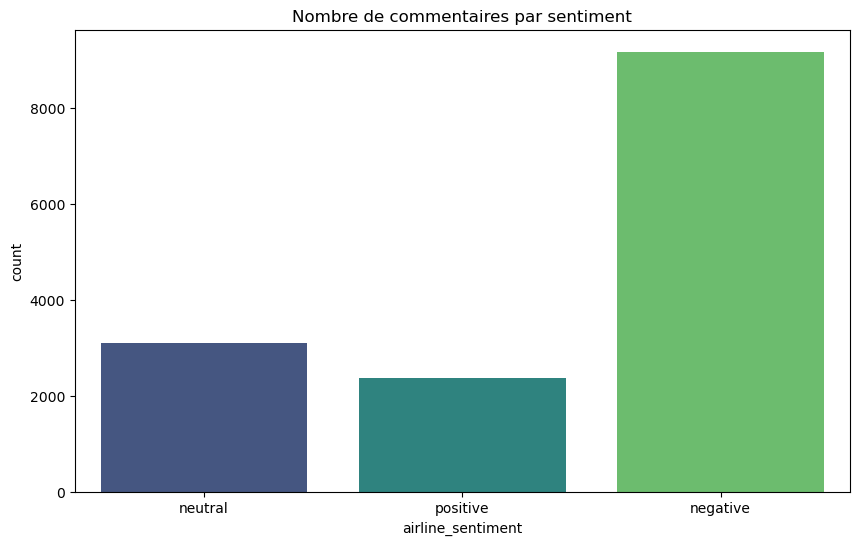

In [53]:
plt.figure(figsize=(10,6))
sns.countplot(x='airline_sentiment',data=df, palette='viridis')
plt.title('Nombre de commentaires par sentiment')
plt.show()

On remarque qu'il y a plus de commentaire négatif que de commentaire positif. 

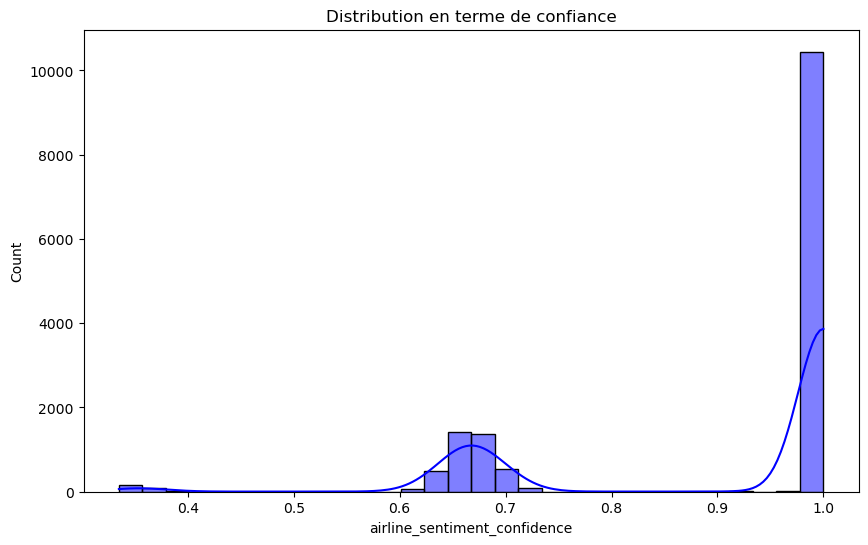

In [54]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='airline_sentiment_confidence', bins=30, kde=True, color='blue')
plt.title('Distribution en terme de confiance')
plt.show()

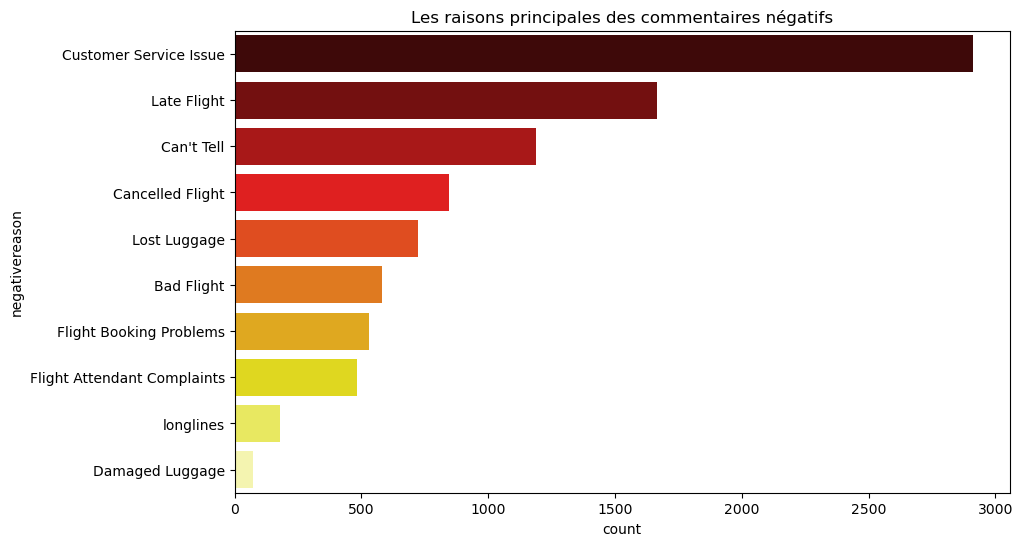

In [55]:
plt.figure(figsize=(10,6))
sns.countplot(y='negativereason', data=df, order=df['negativereason'].value_counts().index, palette="hot")
plt.title('Les raisons principales des commentaires négatifs')
plt.show()

In [56]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

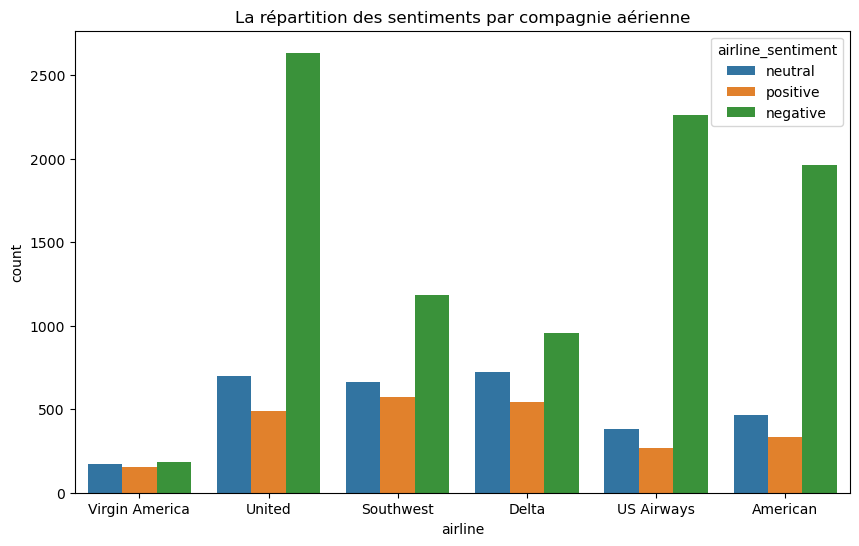

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', hue='airline_sentiment', data=df)
plt.title('La répartition des sentiments par compagnie aérienne')
plt.show()

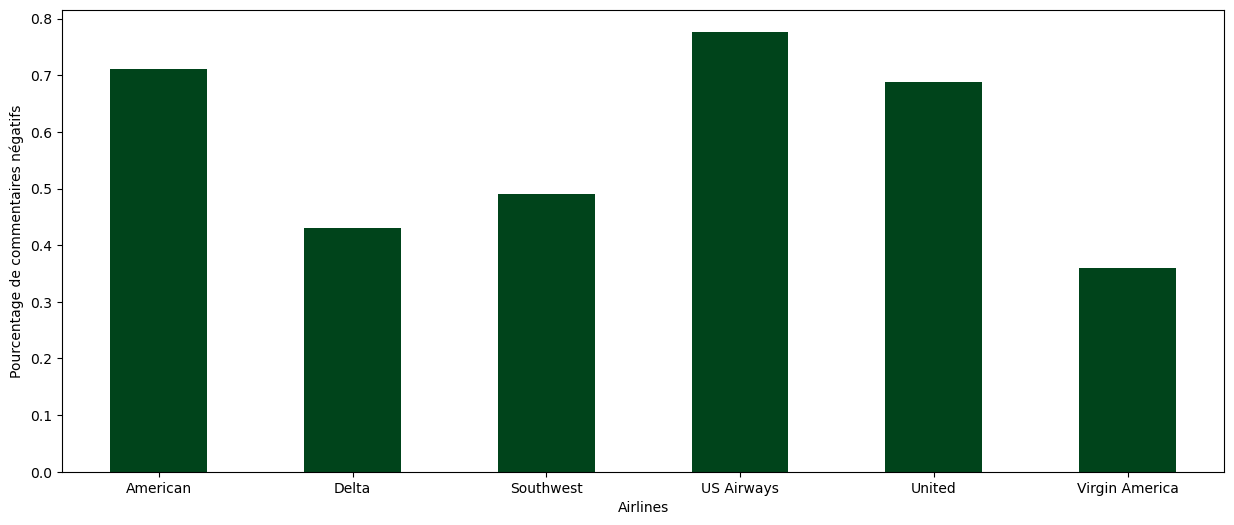

In [58]:
neg_tweets = df.groupby(['airline', 'airline_sentiment']).size().unstack().iloc[:, 0]
total_tweets = df['airline'].value_counts()

perc = neg_tweets / total_tweets
perc.columns = ['Percent Negative']

ax = perc.plot(kind='bar', rot=0, colormap='Greens_r', figsize=(15, 6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Pourcentage de commentaires négatifs')
plt.show()

On remarque que US Airways, American et United, sont les companies aérienne ayant le plus de commentaire négatif

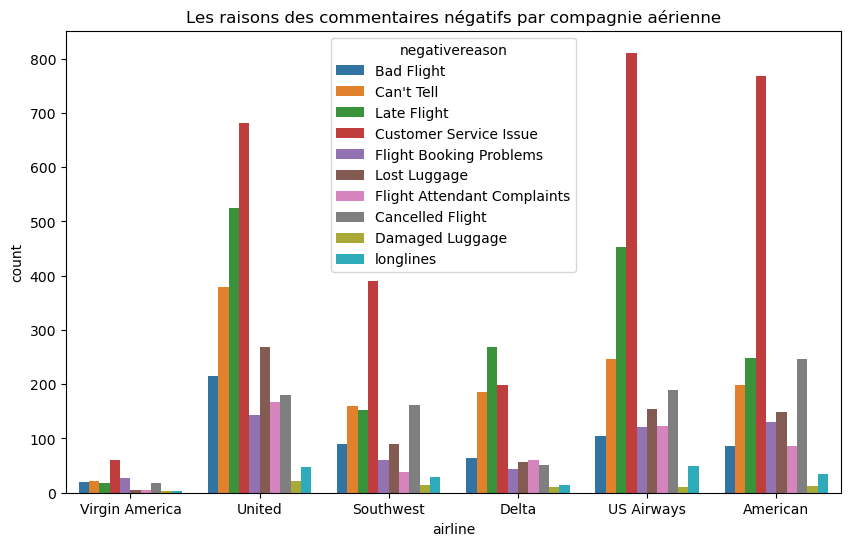

In [85]:
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', hue='negativereason', data=df)
plt.title('Les raisons des commentaires négatifs par compagnie aérienne')
plt.show()


On comprends donc que globalement, la raison principales de commentaires négatifs est le service client, suivi des retards de vol.

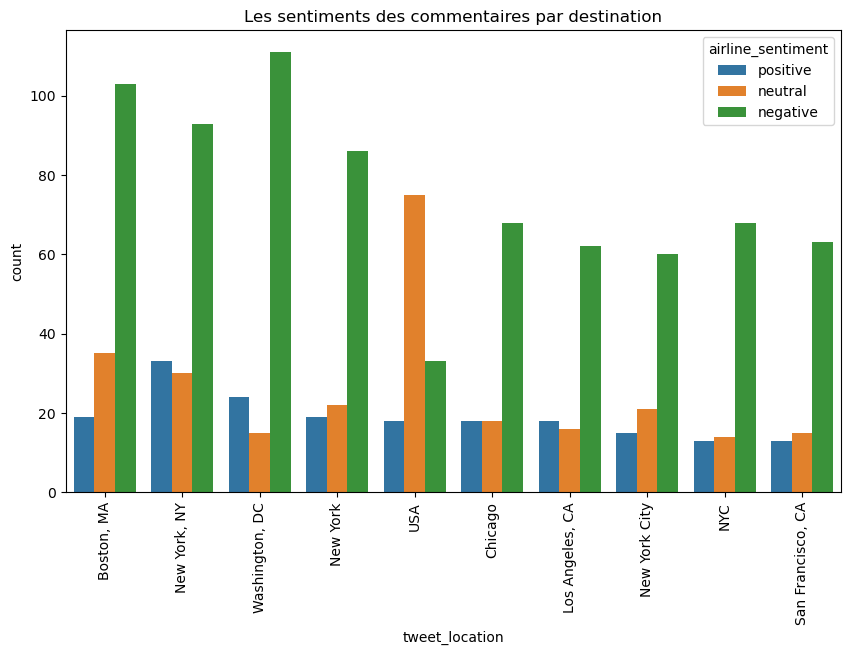

In [86]:
top_destinations = df['tweet_location'].value_counts().head(10).index
df_top_destinations = df[df['tweet_location'].isin(top_destinations)]


plt.figure(figsize=(10, 6))
sns.countplot(x='tweet_location', hue='airline_sentiment', data=df_top_destinations, order=top_destinations)
plt.title('Les sentiments des commentaires par destination')
plt.xticks(rotation=90)

plt.show()


<Figure size 1000x1000 with 0 Axes>

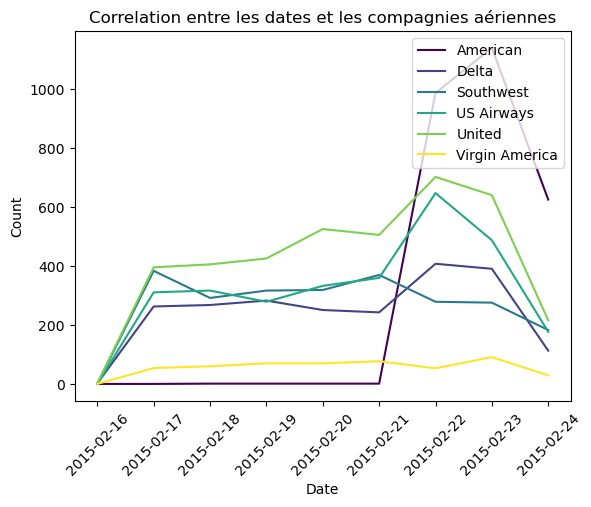

In [61]:
plt.figure(figsize=(10, 10))
correlation = df.groupby(['tweet_created', 'airline']).size().unstack().fillna(0)
correlation.plot(kind='line', cmap='viridis')
plt.title('Correlation entre les dates et les compagnies aériennes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xticks(rotation=45)  
plt.show()



On remarque donc qu'il existe une correlation entre la date de creation du tweet et les problèmes sur les companies. En effet, entre le 20/02 et le 23 , on constate un pique de problème. 

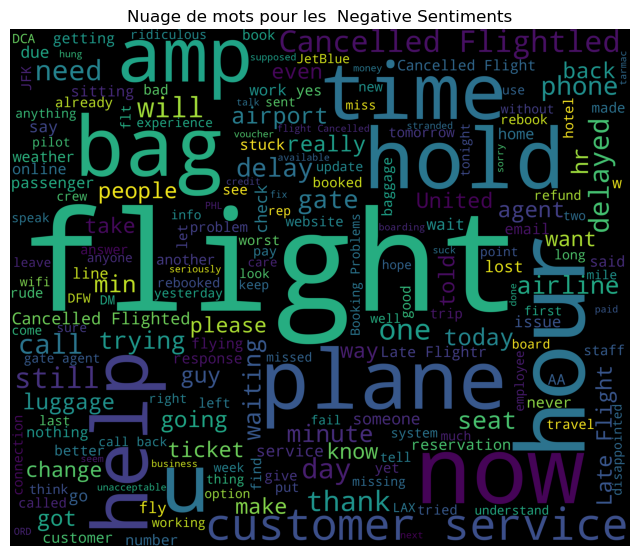

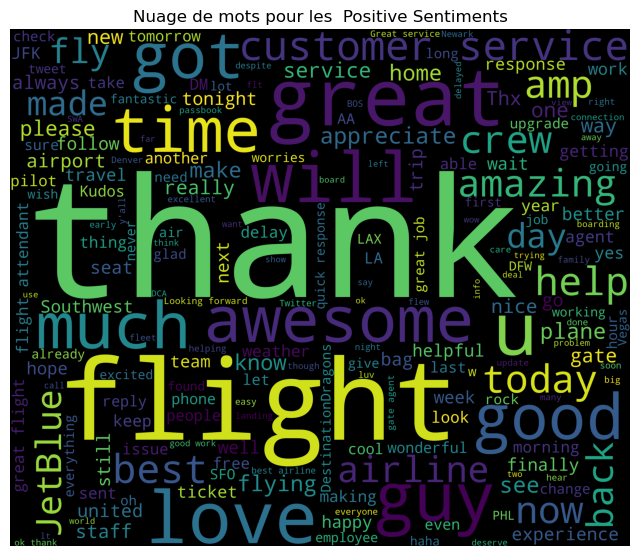

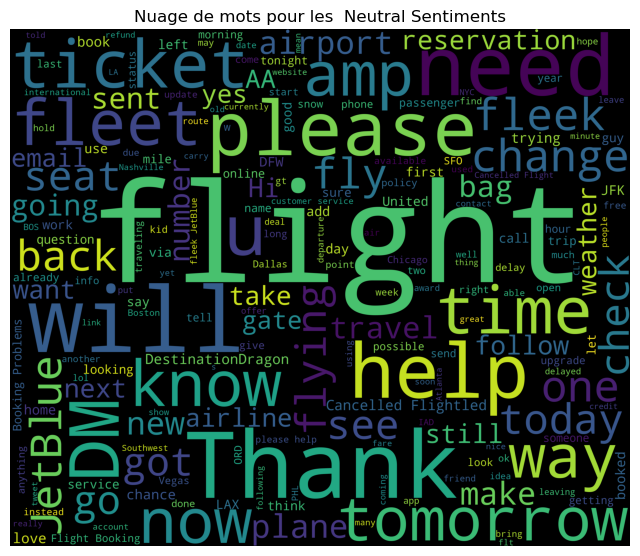

In [62]:
def generate_wordcloud(sentiment):
    sentiment_df = df[df['airline_sentiment'] == sentiment]

    sentiment_text = ' '.join(sentiment_df['text'])
    cleaned_sentiment_text = " ".join([word for word in sentiment_text.split()
                                       if 'http' not in word
                                       and not word.startswith('@')
                                       and word != 'RT'
                                       ])

    # Generate word cloud
    sentiment_wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='black',
        width=3000,
        height=2500,
        colormap='viridis'
    ).generate(cleaned_sentiment_text)

    plt.figure(1, figsize=(8, 8))
    plt.imshow(sentiment_wordcloud)
    plt.title(f'Nuage de mots pour les  {sentiment.capitalize()} Sentiments')
    plt.axis('off')
    plt.show()

generate_wordcloud('negative')
generate_wordcloud('positive')
generate_wordcloud('neutral')

In [63]:
df.drop(columns = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], inplace=True)


## Machine learning

In [81]:
X = df[df['airline_sentiment'] != 'neutral']['text']
y = df[df['airline_sentiment'] != 'neutral']['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(class_weight='balanced'))
])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


report = classification_report(y_test, y_pred, output_dict=True)


report_df = pd.DataFrame(report).transpose()




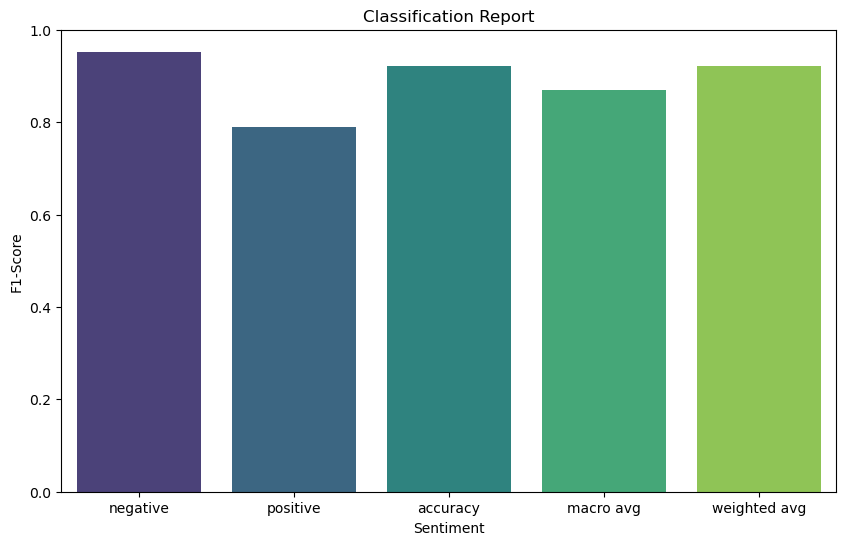

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df, palette='viridis')
plt.title('Classification Report')
plt.xlabel('Sentiment')
plt.ylabel('F1-Score')
plt.show()

In [82]:
report_df

,precision,recall,f1-score,support
negative,0.940377,0.965628,0.952835,1862.00000
positive,0.838791,0.744966,0.789100,447.00000
accuracy,0.922910,0.922910,0.922910,0.92291
macro avg,0.889584,0.855297,0.870967,2309.00000
weighted avg,0.920711,0.922910,0.921138,2309.00000


In [66]:

new_message = "I hate this airline! The service is terrible and the flight was delayed for hours. Never flying with them again!"

predicted_sentiment = pipeline.predict([new_message])[0]

print("Sentiment prédit:", predicted_sentiment)


Sentiment prédit: negative


In [67]:
dump(pipeline, 'model.joblib')

['model.joblib']